# Forest fire

we're checking if the fire will get to the other side

In [285]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation

Jak mamy $n$ agentów w systemie, tzn. że $n$ małych updatów to jest jeden krok MC.

In [139]:
def gen_env(L, p):
    env = np.random.choice([0,1], (L,L), p=[1-p, p])
    env[:,0] = 2 * env[:,0]
    return env

In [140]:
L = 20 #one dim size, so matrix (L,L)
p=0.1 #density, probability of a space being populated with a tree
base_env = gen_env(L, p)

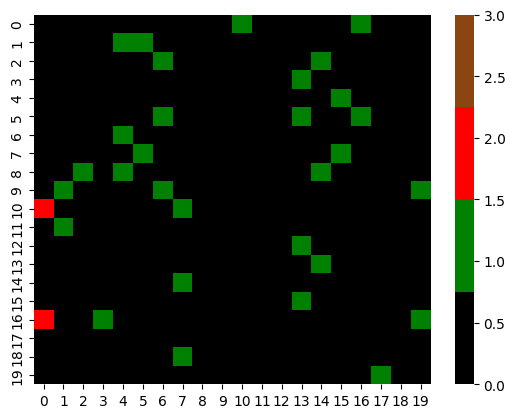

In [294]:
sns.heatmap(base_env, vmin=0, vmax=3, cmap=['black', 'green', 'red', 'saddlebrown'])
plt.show()

In [260]:
class ClusterCounter:
    
    def __init__(self, env):
        self.burnt_env = np.zeros((env.shape[0]+2, env.shape[1]+2), dtype=int)
        self.burnt_env[1:-1, 1:-1] = (env.copy()==3)
        self.max_label = 0
        self.label = np.zeros(self.burnt_env.shape, dtype=int)
        self.labels = np.arange(self.burnt_env.size+1, dtype=int)

    def get_label(self, tag):
        y = tag.copy()
        while self.labels[y] != y:
            y = self.labels[y].copy()
        while self.labels[tag] != tag:
            z = self.labels[tag].copy()
            self.labels[tag] = y
            tag = z.copy()
        return y.copy()

    def union_labels(self, tags):
        last_tag = tags.pop()
        for tag in tags:
            self.labels[self.get_label(tag)] = self.get_label(last_tag)

    def find_clusters(self):
        for j in range(1, self.burnt_env.shape[1]-1):
            for i in range(1, self.burnt_env.shape[0]-1):
                if self.burnt_env[i,j]>0:
                    l = self.label[i, j-1]
                    t = self.label[i-1, j]
                    c = self.label[i-1, j-1]
                    if l+t+c == 0:
                        self.max_label += 1 #new label coz no neibhours have one
                        self.label[i,j] = self.max_label
                    elif (l>0) and (t+c == 0):
                        self.label[i,j] = self.get_label(l)
                    elif (t>0) and (l+c == 0):
                        self.label[i,j] = self.get_label(t)
                    elif (c>0) and (t+l == 0):
                        self.label[i,j] = self.get_label(c)
                    else:
                        filled_neigh = list(filter(lambda x: x>0, [l,t,c]))
                        self.union_labels(filled_neigh)
                        self.label[i,j] = self.get_label(filled_neigh[0])        
        return self.label[1:-1, 1:-1]
    
    def find_max_cluster(self):
        clusters = self.find_clusters().ravel()
        if clusters.sum() == 0:
            return 0
        non_empty = list(filter(lambda x: x>0, clusters))
        _, counts = np.unique(non_empty, return_counts=True)
        return max(counts)
        
#implement but remember that there is a diff neighbourhood, cluster size

In [261]:
def get_neigh(L, x, y):
    neigh_border = np.array([max(0, x-1),min(L, x+2), max(0, y-1), min(L, y+2)])
    return neigh_border

def update(env):
    base_env = env.copy()
    x,y = np.where(base_env==2)
    for i in range(len(x)):
        x_min, x_max, y_min, y_max = get_neigh(base_env.shape[0], x[i], y[i])
        env[x_min:x_max, y_min:y_max] = base_env[x_min:x_max, y_min:y_max] + (base_env[x_min:x_max, y_min:y_max]==1)
    env += (base_env == 2)
    return env.copy()

def sim(env):
    while np.where(env==2)[0].size > 0:
        env = update(env)
    return env

def run_forest_fire(L, ps, M):
    ms = []
    cs = []
    for p in ps:
        m = 0
        c = 0
        for i in range(M):
            env = gen_env(L, p)
            env = sim(env)
            m += 1 if sum(env[:,-1]==3) > 0 else 0
            c += ClusterCounter(env).find_max_cluster()
        cs.append(c/M)
        ms.append(m/M)
        
    return ms, cs

In [279]:
def get_full_sim(env):
    full_states = [env.copy()]
    while np.where(env==2)[0].size > 0:
        env = update(env)
        full_states.append(env.copy())
    return full_states

$L=20$

In [280]:
sample_env_burn = gen_env(L=20, p=0.5)
sample_env_burn = get_full_sim(sample_env_burn)
sample_env_safe = gen_env(L=20, p=0.2)
sample_env_safe = get_full_sim(sample_env_safe)

In [295]:
def make_animation(state, step):
    plt.clf()  
    plt.title(f"State at {step} MCS")
    sns.heatmap(state, vmin=0, vmax=3, cmap=['black', 'green', 'red', 'saddlebrown'])
    return plt

In [296]:
def animate(step):
    make_animation(sample_env_burn[step], step)

fig = plt.figure()
anim = FuncAnimation(fig, animate, frames=len(sample_env_burn), interval=1, repeat=False)
anim.save("states_20_burn.gif")
plt.close(fig)

In [297]:
def animate(step):
    make_animation(sample_env_safe[step], step)

fig = plt.figure()
anim = FuncAnimation(fig, animate, frames=len(sample_env_safe), interval=1, repeat=False)
anim.save("states_20_safe.gif")
plt.close(fig)

$L=100$

In [298]:
sample_env_burn100 = gen_env(L=100, p=0.5)
sample_env_burn100 = get_full_sim(sample_env_burn100)
sample_env_safe100 = gen_env(L=100, p=0.2)
sample_env_safe100 = get_full_sim(sample_env_safe100)

In [299]:
def animate(step):
    make_animation(sample_env_burn100[step], step)

fig = plt.figure()
anim = FuncAnimation(fig, animate, frames=len(sample_env_burn100), interval=1, repeat=False)
anim.save("states_100_burn.gif")
plt.close(fig)

In [300]:
def animate(step):
    make_animation(sample_env_safe100[step], step)

fig = plt.figure()
anim = FuncAnimation(fig, animate, frames=len(sample_env_safe100), interval=1, repeat=False)
anim.save("states_100_safe.gif")
plt.close(fig)

## Monte Carlo simulation 

In [265]:
M=100
Ls = [20,50,100]
ps = np.arange(0,1.01,0.01)
ms = np.zeros((len(Ls),len(ps)))
clusters = np.zeros((len(Ls),len(ps)))
for n in range(len(Ls)):
    m_t, c_t = run_forest_fire(Ls[n], ps, M)
    ms[n,:] = m_t
    clusters[n,:] = c_t

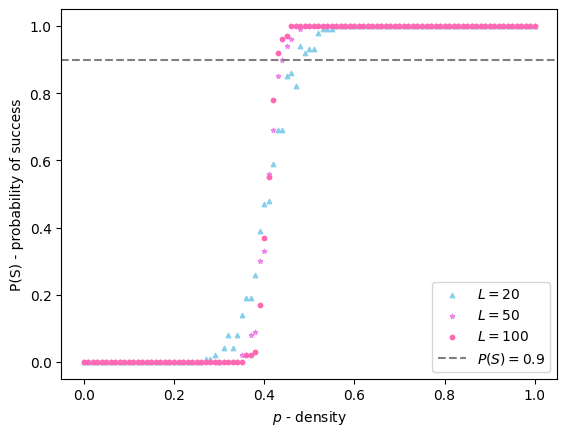

In [266]:
marker_dict = {20: '^',
               50: '*',
               100: 'o'}
color_dict = {20: 'skyblue',
              50: 'violet',
              100: 'hotpink'}

for n in range(len(Ls)):
    plt.scatter(ps, 
                ms[n,:], 
                marker=marker_dict[Ls[n]], 
                s=10, 
                c = color_dict[Ls[n]], 
                label = f'$L={Ls[n]}$')
plt.axhline(y=0.9, linestyle='--', color='gray', label='$P(S)=0.9$')
plt.xlabel('$p$ - density')
plt.ylabel('P(S) - probability of success')
plt.legend()
plt.show()

In [271]:
for i in range(3):
    pq = ps[np.where(np.asarray(ms[0,:])>0.9)[0][0]]
    print(f'With L={Ls[i]} for p*={pq}, P(S) exceeds 0.9')

With L=20 for p*=0.48, P(S) exceeds 0.9
With L=50 for p*=0.48, P(S) exceeds 0.9
With L=100 for p*=0.48, P(S) exceeds 0.9


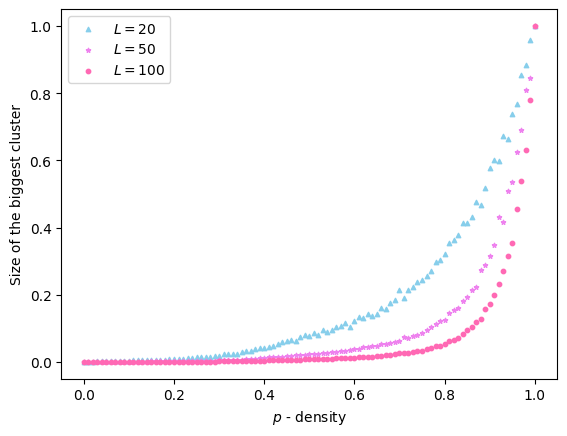

In [268]:
for n in range(len(Ls)):
    plt.scatter(ps, 
                list(map(lambda x: x/(Ls[n]**2), clusters[n,:])), 
                marker=marker_dict[Ls[n]], 
                s=10, 
                c = color_dict[Ls[n]], 
                label = f'$L={Ls[n]}$')
plt.xlabel('$p$ - density')
plt.ylabel('Size of the biggest cluster')
plt.legend()
plt.show()

p* tam gdzie P of success P(S) jest powyżej 0.9

GIF or shots 3x3 co ileś kroków

In [64]:
for i in range(len(x)):
    print(x[i])

3
8
16
18


Unormowane /L^2 size of cluster(p)

In [72]:
get_neigh(20, 0, 0)

array([0, 1, 0, 1])

In [69]:
x=1
y=1
np.array([x-1,x+1, y-1, y+1])>0

array([False,  True, False,  True])

Bonusowe punkty:

Wind:
* Wiatr tylko pomaga, czyli jeśli gdzieś wieje to tam jeszcze extra pole
* Wiatr przeszkadza, czyli nie rozprzestrzenia się do tyłu (tutaj raczej wiatr góra dół)
* I blokuje i pomaga

Można rozważać z siłą wiatru

Raczej dwa wiatry czy coś

I dorobić to samo

In [57]:
env.shape

(20, 20)

Wyniki:

GIF
P(S) od p dla trzech rozmiarów, legenda, trójkąty gwiazdki